In [35]:
#Our goal here is to identify different types of wafer map failure pattern automatically, so that its construction can
#be improved, by increasing the accuracy of the manufacturing process.

# Importing the libraries

import os
from os.path import join

import numpy as np
import pandas as pd
import scipy.io as sio

import tensorflow as tf
import keras
from keras import layers, Input, models
#from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

df=pd.read_pickle("LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [7]:
df = df.drop(['waferIndex'], axis = 1)

In [8]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
527092,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2,...",515.0,lot32972,[],[],"(25, 27)"
112542,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot7566,[],[],"(26, 26)"
221380,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...",1075.0,lot13969,[[Training]],[[Edge-Ring]],"(38, 36)"
315968,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1226.0,lot19230,[],[],"(40, 40)"
697138,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",516.0,lot42908,[[Training]],[[none]],"(25, 27)"


In [9]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [10]:
tol_wafers = df.shape[0]
tol_wafers


811457

In [11]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

In [12]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [13]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [14]:
x = x.reshape((-1, 26, 26, 1))

In [15]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [16]:
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [17]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [18]:
epoch=30
batch_size=1024


In [19]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Epoch 1/30
15/15 - 27s - loss: 0.1580 - 27s/epoch - 2s/step
Epoch 2/30
15/15 - 26s - loss: 0.0962 - 26s/epoch - 2s/step
Epoch 3/30
15/15 - 27s - loss: 0.0863 - 27s/epoch - 2s/step
Epoch 4/30
15/15 - 29s - loss: 0.0752 - 29s/epoch - 2s/step
Epoch 5/30
15/15 - 29s - loss: 0.0660 - 29s/epoch - 2s/step
Epoch 6/30
15/15 - 28s - loss: 0.0587 - 28s/epoch - 2s/step
Epoch 7/30
15/15 - 28s - loss: 0.0529 - 28s/epoch - 2s/step
Epoch 8/30
15/15 - 26s - loss: 0.0483 - 26s/epoch - 2s/step
Epoch 9/30
15/15 - 27s - loss: 0.0439 - 27s/epoch - 2s/step
Epoch 10/30
15/15 - 26s - loss: 0.0391 - 26s/epoch - 2s/step
Epoch 11/30
15/15 - 27s - loss: 0.0345 - 27s/epoch - 2s/step
Epoch 12/30
15/15 - 27s - loss: 0.0304 - 27s/epoch - 2s/step
Epoch 13/30
15/15 - 27s - loss: 0.0269 - 27s/epoch - 2s/step
Epoch 14/30
15/15 - 28s - loss: 0.0241 - 28s/epoch - 2s/step
Epoch 15/30
15/15 - 27s - loss: 0.0218 - 27s/epoch - 2s/step
Epoch 16/30
15/15 - 26s - loss: 0.0198 - 26s/epoch - 2s/step
Epoch 17/30
15/15 - 26s - loss: 0

In [20]:
encoder = models.Model(input_tensor, latent_vector)


In [21]:
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [22]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

In [23]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

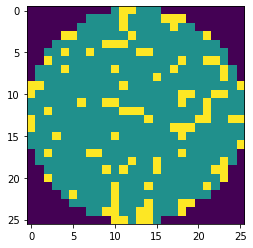

In [24]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

In [25]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
  # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

In [27]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

In [28]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13489


In [29]:
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]

In [30]:
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [31]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 2489


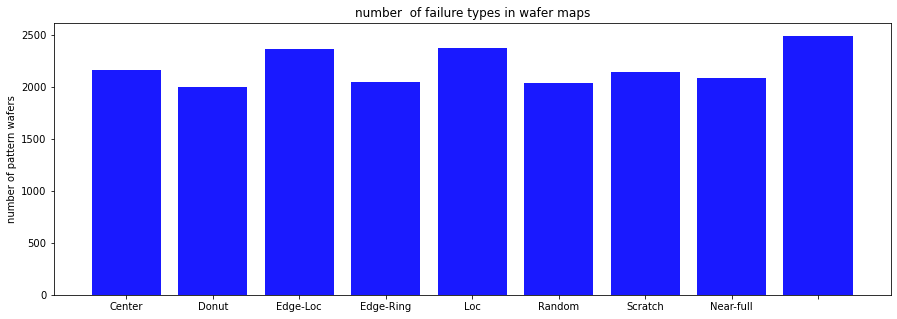

In [32]:
%matplotlib inline

fig = plt.figure(figsize=(15, 5))
axe=plt.subplot(1,1,1)

uni_pattern=np.unique(new_y, return_counts=True)
labels = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
axe.bar(uni_pattern[0],uni_pattern[1], color='blue', align='center', alpha=0.9)
axe.set_title("number  of failure types in wafer maps")
axe.set_ylabel("number of pattern wafers")
axe.set_xticklabels(labels)

plt.show()




In [36]:
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# one-hot-encoding
new_y = to_categorical(new_y)

In [37]:
new_X=new_x[0:19000]
new_Y=new_y[0:19000]
test_x=new_x[19001:19706]
test_y=new_y[19001:19706]
test_x.shape


(705, 26, 26, 3)

In [38]:
x_train, x_test, y_train, y_test = train_test_split(new_X, new_Y,
                                                    test_size=0.33,
                                                    random_state=2019)

In [40]:
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [41]:
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/30
9/9 - 71s - loss: 2.4616 - accuracy: 0.2833 - 71s/epoch - 8s/step
Epoch 2/30
9/9 - 60s - loss: 1.1006 - accuracy: 0.6578 - 60s/epoch - 7s/step
Epoch 3/30
9/9 - 60s - loss: 0.7767 - accuracy: 0.7211 - 60s/epoch - 7s/step
Epoch 4/30
9/9 - 56s - loss: 0.5097 - accuracy: 0.8264 - 56s/epoch - 6s/step
Epoch 5/30
9/9 - 55s - loss: 0.3134 - accuracy: 0.8924 - 55s/epoch - 6s/step
Epoch 6/30
9/9 - 54s - loss: 0.1843 - accuracy: 0.9449 - 54s/epoch - 6s/step
Epoch 7/30
9/9 - 55s - loss: 0.1247 - accuracy: 0.9650 - 55s/epoch - 6s/step
Epoch 8/30
9/9 - 55s - loss: 0.0667 - accuracy: 0.9839 - 55s/epoch - 6s/step
Epoch 9/30
9/9 - 57s - loss: 0.0426 - accuracy: 0.9903 - 57s/epoch - 6s/step
Epoch 10/30
9/9 - 79s - loss: 0.0242 - accuracy: 0.9965 - 79s/epoch - 9s/step
Epoch 11/30
9/9 - 54s - loss: 0.0165 - accuracy: 0.9976 - 54s/epoch - 6s/step
Epoch 12/30
9/9 - 56s - loss: 0.0126 - accuracy: 0.9984 - 56s/epoch - 6s/step
Epoch 13/30
9/9 - 47s - loss: 0.0096 - accuracy: 0.9988 - 47s/epoch - 5s/

In [42]:
history = model.fit(x_train, y_train,
         validation_data=[x_test, y_test],
         epochs=epoch,
         batch_size=batch_size,
         )

Epoch 1/30
13/13 - 69s - loss: 1.5120 - accuracy: 0.4939 - val_loss: 0.6786 - val_accuracy: 0.7396 - 69s/epoch - 5s/step
Epoch 2/30
13/13 - 60s - loss: 0.5337 - accuracy: 0.8053 - val_loss: 0.5728 - val_accuracy: 0.8676 - 60s/epoch - 5s/step
Epoch 3/30
13/13 - 58s - loss: 0.4340 - accuracy: 0.8595 - val_loss: 0.2753 - val_accuracy: 0.9132 - 58s/epoch - 4s/step
Epoch 4/30
13/13 - 58s - loss: 0.2036 - accuracy: 0.9432 - val_loss: 0.1321 - val_accuracy: 0.9665 - 58s/epoch - 4s/step
Epoch 5/30
13/13 - 58s - loss: 0.0853 - accuracy: 0.9783 - val_loss: 0.0535 - val_accuracy: 0.9896 - 58s/epoch - 4s/step
Epoch 6/30
13/13 - 60s - loss: 0.0345 - accuracy: 0.9933 - val_loss: 0.0352 - val_accuracy: 0.9914 - 60s/epoch - 5s/step
Epoch 7/30
13/13 - 63s - loss: 0.0221 - accuracy: 0.9950 - val_loss: 0.0325 - val_accuracy: 0.9922 - 63s/epoch - 5s/step
Epoch 8/30
13/13 - 59s - loss: 0.0167 - accuracy: 0.9969 - val_loss: 0.0223 - val_accuracy: 0.9951 - 59s/epoch - 5s/step
Epoch 9/30
13/13 - 59s - loss: 0

In [43]:
score = model.score(x_test, y_test)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score)

7/7 - 12s - loss: 0.0246 - accuracy: 0.9931 - 12s/epoch - 2s/step
Testing Accuracy: 0.9931419491767883


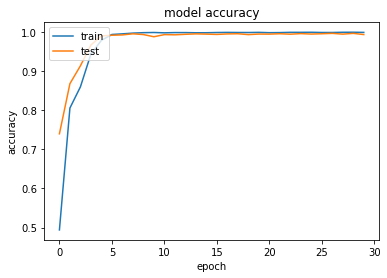

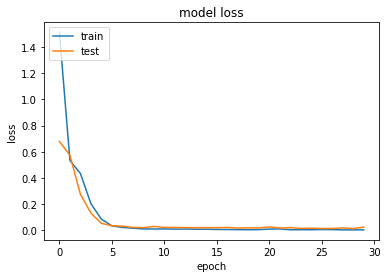

In [45]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()